In [118]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from operator import itemgetter

import csv
import spacy
import re

In [119]:
nlp = spacy.load("en")

tweets = []

with open("tweets-dataset.csv", "r", encoding="UTF-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        tweets.append(row['Sentence'])

print(len(tweets))

24521


In [120]:
#Print a small sample
print(*tweets[0:5], sep="\n")

@BubblyDentist @MeetUunngLee nahi nahi, mere saath jaakar pachtaogi. Ye Uunnglee is the best. All girls say that
going to the grammys first entertainment law breakfast here in nyc tomorrow !  i'm so excited .  one step closer .  .  .
bohot hi badiya ji aap sunao?
Parvez Musharraf is Digvijay Singh of Pakistanhttps://twitter.com/IndiaToday/status/599994321610285058 …
guddu ko bass john cena k sticker ki padii hai :d :d


Note that many tweets are in hindi but are written in roman script.

## TTR

We want to calculate the TTR (Type Token Ratio) which will roughly give us an idea of, on average, how frequently a new word form appears in the corpus.

In [ ]:
#We perform basic cleanup of text like removing urls, mentions, and hashtags. For calculating the TTR, we ignore the punctuations and space and other special symbols(eg: :D, :p etc).

word_list = []
word_pos_dict = defaultdict()

lemma_list = []
lemma_pos_dict = defaultdict()

cleaned_tweets_list = []

url_pattern = re.compile("http[s]?://[a-zA-Z.//_0-9/-]*[a-z]?")
mention_pattern = re.compile("@[a-zA-Z0-9_]*")
hashtag_pattern = re.compile("#[a-zA-Z]*")

for tweet in tweets:
    
    url_cleaned_tweet = re.sub(url_pattern, " ", tweet)
    mention_cleaned_tweet = re.sub(mention_pattern, " ", url_cleaned_tweet)
    cleaned_tweet = re.sub(hashtag_pattern, " ", mention_cleaned_tweet)
    
    cleaned_tweets_list.append(cleaned_tweet)
    
    doc = nlp(cleaned_tweet)
    for s in doc.sents:
        for token in s:
            word = token.text.lower()
            if token.pos_ not in ["PUNCT", "SPACE", "SYM"]:
                word_list.append(word)
                lemma_list.append(token.lemma_)
                
                if word in word_pos_dict:
                    word_pos_dict[word].add(token.pos_)
                else:
                    word_pos_dict[word] = set({token.pos_, })
                
                if token.lemma_ in lemma_pos_dict:
                    lemma_pos_dict[token.lemma_].add(token.pos_)
                else:
                    lemma_pos_dict[token.lemma_] = set({token.pos_, })

In [11]:
print(len(word_list))
print(len(word_pos_dict))

295063
32297


Ideally we should use lemma to calculate TTR but since the language is hindi written in roman script, we don't have appropriate models for this, and hence we use the space delimited words only for calculation of TTR. 

We check the lemmatized list of words but drop it from further analysis as the lemmatization is not appropriate.

Computation of Type Token Ratio (TTR) = #types/#tokens

In [13]:
type_counter = Counter(word_list)

type_count = len(type_counter)
# print(type_count)

token_count = len(word_list)
# print(token_count)

TTR = type_count/token_count

print("TTR = ", TTR)

32297
295063
0.10945798016016918


In [14]:
#Top 10 frequently occuring types
type_counter.most_common(10)

[('hai', 10079),
 ('to', 4124),
 ('ki', 3216),
 ('nahi', 3171),
 ('ke', 3170),
 ('bhi', 2927),
 ('the', 2859),
 ('se', 2599),
 ('ho', 2344),
 ('ka', 2304)]

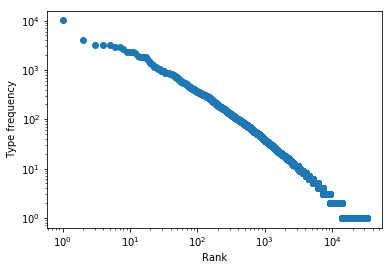

In [16]:
# Plot the power law of frequency and rank
import matplotlib.pyplot as plt
plt.scatter(list(range(1, len(type_counter)+1)), sorted(list(type_counter.values()), reverse=True))
plt.xlabel('Rank')
plt.ylabel('Type frequency')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [18]:
import pickle

with open('wordlist1.pkl', 'wb') as f:
    pickle.dump(word_list, f)

with open('wordposdict1.pkl', 'wb') as f:
    pickle.dump(word_pos_dict, f)


In [116]:
word_freq = Counter(word_list)
print(word_freq.most_common(20))


[('hai', 10079), ('to', 4124), ('ki', 3216), ('nahi', 3171), ('ke', 3170), ('bhi', 2927), ('the', 2859), ('se', 2599), ('ho', 2344), ('ka', 2304), ('bhai', 2260), ('ko', 2211), ('me', 1949), ('ye', 1863), ('kya', 1811), ('hi', 1796), ('aur', 1790), ('kar', 1684), ('i', 1515), ('in', 1372)]


# Zipf's Law

1. Plot the power law of frequency and rank. $\text{frequency} \propto \frac{1}{\text{Rank}}$

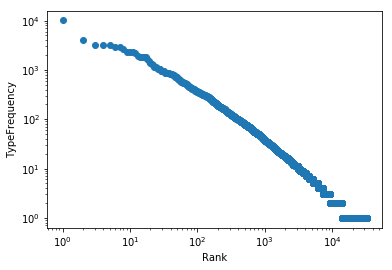

In [73]:
plt.scatter(list(range(1, len(type_counter)+1)), sorted(list(type_counter.values()), reverse=True))
plt.xlabel('Rank')
plt.ylabel('TypeFrequency')
plt.xscale('log')
plt.yscale('log')
plt.show()

We get a straight line on the log-log plot.

2. Zipf's law for meaning: $\text{#meanings} \propto \sqrt{\text{frequency}} \propto \frac{1}{\sqrt{\text{Rank}}}$

In [117]:
freq_sorted_words = sorted(list(type_counter.items()), key=itemgetter(1), reverse=True)
print(freq_sorted_words[0:10])

[('hai', 10079), ('to', 4124), ('ki', 3216), ('nahi', 3171), ('ke', 3170), ('bhi', 2927), ('the', 2859), ('se', 2599), ('ho', 2344), ('ka', 2304)]


We have multiple meanings of the same word in hindi. For eg: safai means cleanliness and justification both, aam means mango and ordinary, baal means student and hair strand. However, we don't have enough data to emperically evaluate the value of k in $#meaning \propto \frac{1}{\sqrt{rank}}$

3. Zipf's law for word length and frequency: $\text{length} \propto \frac{1}{\text{frequency}} \propto \text{rank}$

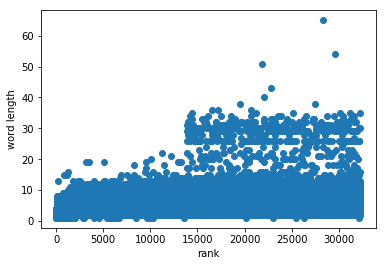

In [115]:
#Rank vs Word length plot
word_lengths_rank_sorted = [len(x[0]) for x in freq_sorted_words]

# vowels = ['a', 'e', 'i', 'o', 'u']
# wl_rank_sorted = []
# for word in freq_sorted_words:
#     tok = word[0]
#     if tok:
#         for v in vowels:
#             tok = tok.replace(v, '')
#         wl_rank_sorted.append(len(tok))

plt.scatter(list(range(1, len(word_lengths_rank_sorted)+1)), word_lengths_rank_sorted)
plt.xlabel('rank')
plt.ylabel('word length')
plt.show()

We expect a straight line as the length of the word is directly proportional to it's rank. However, the issue is that we are counting the length of the words in roman script while the tokens are actually a mix of hindi and english words. Also, one more issue is that we haven't lemmatized the words.

## Heap's Law:    $|V| = k N^{\beta}$

V = Vocab, N = Number of tokens; typically k $\approx$ 10-100 and $\beta$ $\approx$ 0.4-0.6

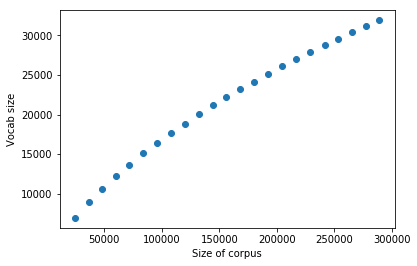

In [114]:
len(cleaned_tweets_list)

vocab = set()
corpus_size = []
vocab_size = []

corpus_len = 0

for i in range(0, len(cleaned_tweets_list)):
    doc = nlp(cleaned_tweets_list[i])
    for s in doc.sents:
        for token in s:
            word = token.text.lower()
            if token.pos_ not in ["PUNCT", "SPACE", "SYM"]:
                vocab.add(word)
                corpus_len = corpus_len + 1
    if i>1000 and i%1000==0:
        corpus_size.append(corpus_len)
        vocab_size.append(len(vocab))

plt.scatter(corpus_size, vocab_size)
plt.xlabel('Size of corpus')
plt.ylabel('Vocab size')
plt.show()

Curve fitting to find values of parameters k and $\beta$:

Popt=  [ 0.61031574 14.93231934]


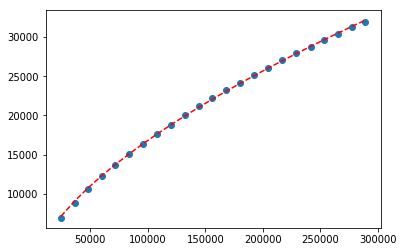

In [113]:
from scipy.optimize import curve_fit

# $|V| = k N^{\beta}$
def func_powerlaw(x, beta, k):
    return x**beta * k

target_func = func_powerlaw
popt, pcov = curve_fit(func_powerlaw, corpus_size, vocab_size, maxfev=2000)
plt.scatter(corpus_size, vocab_size)
plt.plot(corpus_size, target_func(corpus_size, *popt), 'r--')
plt.xlabel('Size of corpus')
plt.ylabel('Vocab size')
print("Popt= ", popt)

From above, we can see that $\beta = 0.61, \text{and k} = 14.93$